<center><h1>PIT - Práctica 1: Análisis de Series Temporales - Modelos Clásicos</h1></center>

---


<center><b>Profesora: Alicia Lozano Díez</b></center>

<center><b>Estudiante: Gloria del Valle Cano</b></center>
 
<center>21 de febrero de 2022</center>


## Objetivo

El objetivo de esta práctica es proporcionar una introducción al procesamiento y análisis de señales temporales: descomposición de una serie temporal para el estudio de sus propiedades, ajuste de modelos lineales (ARIMA) y predicción.

### Materiales - Moodle

- Guión (.ipynb) de la práctica
- Datos (.csv): bases de datos _AirPassengers.csv_ y _COVIDVaccinationCZ.csv_.


# 1. Introducción al procesamiento de señales temporales: Air Passengers

## 1.1. Cargar los datos en Google Colab y manejo de los datos en Python

Primero vamos a descargar el fichero con los datos de la base de datos *AirPassengers.csv* de Moodle, que contiene los datos del número de pasajeros de una aerolínea para un periodo de tiempo.

Las siguientes líneas de código nos permitirán subir el archivo a Google Colab desde el disco local:

In [1]:
from google.colab import files
uploaded = files.upload()

Saving AirPassengers.csv to AirPassengers.csv
Saving COVIDVaccinationCZ.csv to COVIDVaccinationCZ.csv


A continuación, vamos a leer el fichero *AirPassengers.csv* en Python, con la ayuda de la librería *pandas*.

Lo cargaremos haciendo uso también del módulo de Python *datetime* para operar con este tipo de datos de forma cómoda.

La función definida *parser* nos permitirá cambiar el formato de fecha/tiempo al formato que esperamos encontrar en nuestra base de datos.

In [1]:
from pandas import read_csv
from datetime import datetime
 
def parser(x):
	return datetime.strptime(x, '%Y-%m')
 
data = read_csv('AirPassengers.csv', header=0, parse_dates=[0], index_col=0, 
                squeeze=True, date_parser=parser)
print(data.head())

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64


Podemos visualizar cómo está indexada la estructura de datos, así como el número de datos que tiene nuestra serie temporal.

In [3]:
data.index


DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

Si queremos acceder a un dato en concreto, por ejemplo, el número de pasajeros del mes de marzo de 1949, podemos hacerlo de la siguiente forma:

In [4]:
data['1949-03-01']


132

O de esta otra:

In [5]:
data[datetime(1949,3,1)]

132

## 1.2. Representación de los datos


El primer paso para analizar una serie temporal es obtener una representación de los datos, para poder hacernos una idea de las características de la serie de forma visual. 

Para ello, podemos utilizar la librería *matplotlib* como sigue:

Text(0.5, 1.0, 'Serie temporal: Air Passengers')

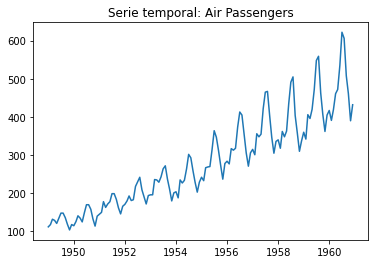

In [2]:
from matplotlib import pyplot as plt
plt.plot(data)
plt.title('Serie temporal: Air Passengers')

## 1.3. Estudio de la estacionariedad de la serie


Algunos de los modelos de análisis de series temporales asumen estacionariedad en las series. Por ello, vamos a ver dos métodos para comprobar si una serie es estacionaria.

Uno de ellos es un análisis más visual: calculamos la media y desviación estándar "móviles" (con una ventana deslizante). 

In [3]:
import pandas as pd

def test_stationarity_1(timeseries,window_size):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window_size).mean()
    rolstd = timeseries.rolling(window=window_size).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

El segundo método consiste en el test estadístico Dickey-Fuller:

In [4]:
import pandas as pd

from statsmodels.tsa.stattools import adfuller
def test_stationarity_2(timeseries):    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [5]:
def test_stationarity(timeseries,window_size):
  test_stationarity_1(timeseries,window_size)
  test_stationarity_2(timeseries)

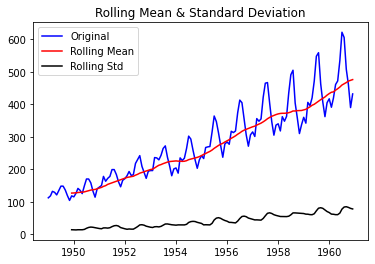

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [6]:
test_stationarity(data, 12)

Ahora cambiamos el tamaño de ventana para hacer las medias móviles.

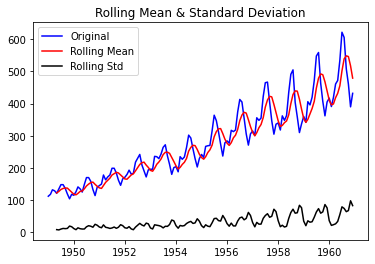

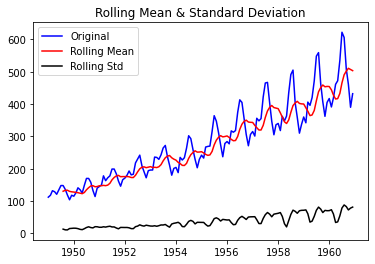

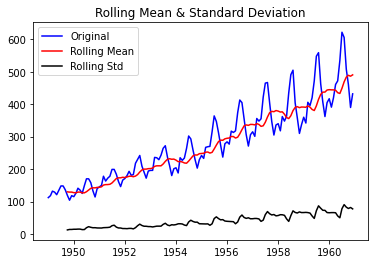

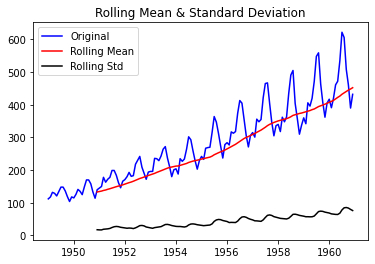

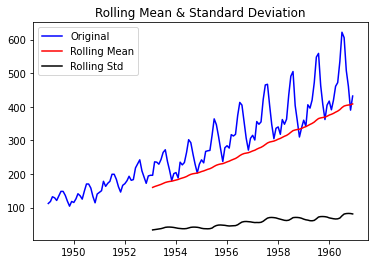

In [11]:
for v in [5, 8, 10, 24, 50]:
  test_stationarity_1(data, v)

Antes de contestar a las preguntas, comprendemos que el test estadístico evalúa la siguiente hipótesis nula:

$H_O$: Existe una raíz unitaria en la serie (modelo autorregresivo).

(Ver más [aquí](https://en.wikipedia.org/wiki/Unit_root)).

Esto nos sirve para evaluar si la serie es estacionaria o no. Para hacer la serie estacionaria podemos hacer lo siguiente:

1. Diferenciar la serie (una vez o más)
2. Tomar el registro de la serie
3. Toma la enésima raíz de la serie
4. Combinación de lo anterior


**PREGUNTAS**

1.   ¿Qué conclusiones puede extraer del análisis de estacionariedad de la serie original?

Tras el primer análisis vemos que la serie no es estacionaria, ya que la media y la desviación típica no se ven constantes con el tiempo. Es decir, podemos ver que sigue una tendencia clara creciente y lo mismo ocurre con la desviación típica. Además vemos que tiene estacionalidad, esto es que parece que se repite un patrón de comportamiento cada año.

Por otra parte, el test de Dickey-Fuller contrasta la hipótesis nula de que el modelo tiene una raíz unitaria. Esto quiere decir que si el modelo tiene una raíz unitaria en su ecuaciónn característia, la serie no será estacionaria. Observando los resultados podemos ver que el p-valor es mayor que el nivel de significancia de $\alpha = 0.05$, por lo que no podemos rechazar la hipótesis nula, lo que significa que el modelo debe ser no estacionario.

2.   ¿Qué diferencias observas al variar el tamaño de la ventana para hacer las medias móviles? Prueba con un par de tamaños, incluye las gráficas obtenidas y explica las diferencias visuales que aprecias.

(Ver arriba). Vemos que cuando aumentamos el tamaño de ventana, esto es, los meses, la media se aproxima a la forma de la gráfica original y aumenta la varianza, mientras que cuando utilizamos tamaños de ventana más pequeños tanto la media como la varianza se van suavizando. Esto nos da la idea de que al usar un tamaño de ventana cada vez más mayor vamos reduciendo cada vez más la componente de estacionalidad clara que tiene esta serie temporal.


## 1.4. Transformar una serie temporal en estacionaria

Como hemos visto en la teoría, para analizar la serie y poder ajustarle un modelo tipo AR, MA o ARMA, esperamos que la serie a modelar sea estacionaria. 

Para conseguir una serie lo más estacionaria posible, podemos aplicar distintas transformaciones de la serie original. Vamos a ver algunos ejemplos:

a) *Transformaciones simples para reducir el efecto de la tendendia*:

En el caso de los datos del ejemplo, la tendencia es positiva, por lo que podemos aplicar alguna transformación que penalice los valores más altos y menos los más bajos. Es el caso del logaritmo, la raíz cuadrada, etc. 

**PREGUNTA**


1.   Representa a continuación la serie aplicándole una transformación logarítmica. ¿Qué observas?



Text(0.5, 1.0, 'Time series log transformation')

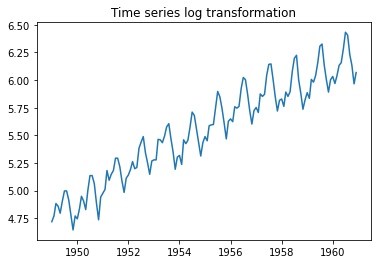

In [8]:
import numpy as np

data_log = np.log(data)
plt.plot(data_log)
plt.title("Time series log transformation")

Como los registros no siguen por así decirlo una normalidad, se corrige aplicando logaritmo, así eliminando parte del sesgo de los datos originales. Vamos a coger diferentes tamaños de ventana y tras ello analizamos los resultados.

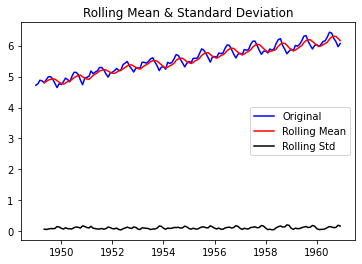

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


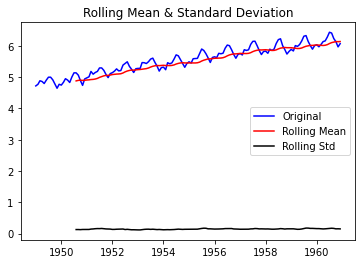

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


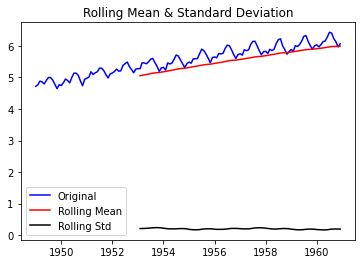

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [13]:
for v in [5, 20, 50]:
  test_stationarity(data_log, v)

Podemos apreciar que la tendencia es ahora mucho más suave, que el crecimiento de la media es también menor y que la desviación típica ya es casi constante. De esta forma hemos penalizado los valores más altos, haciéndolos más cercanos a los valores cada vez menores, consiguiendo así ralentizar la tendencia creciente y aumentando la estacionaridad.

En casos más complejos en los que la tendencia no se ve clara (sobre todo en presencia de ruido), se pueden aplicar otros métodos. Uno de ellos es el suavizado como las medias móviles (*moving average*). 

Por ejemplo, podemos aplicar un suavizado con una media con ventana deslizante que tenga en cuenta un año (12 meses). 
Ten en cuenta, que esto implicará que para calcular la media de las primeras muestras, no tengo suficientes datos para la ventana. Esto lo podemos ver en la salida de la media móvil (tendremos que eliminar los *NaN* que aparecen).


**PREGUNTAS**


1.   Aplica dicha media móvil y represéntala junto a los datos. Puede utilizar los datos en escala logarítmica. ¿Esta media móvil representa claramente la tendencia de la serie?

2.   Elimina ahora de la serie original (transformada con el logaritmo si es como la has calculado previamente) la influencia de esta media móvil y representa el resultado. ¿Qué observas ahora?

3.   Realiza el test de estacionariedad de la serie resultante y compáralo con el de la serie original. ¿Qué conclusiones puedes obtener tanto del test visual como del test estadístico?






**RESPUESTAS**

1. Vamos a aplicar la moving average para los datos, también en escala logarítmica.

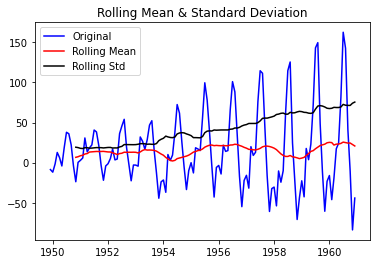

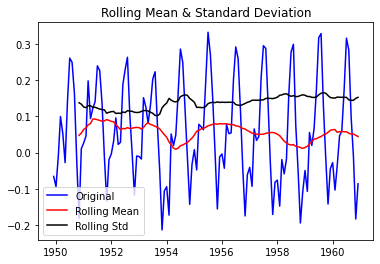

In [9]:
data_sub_mean = (data - data.rolling(window=12).mean().dropna()).dropna()
data_log_sub_mean = (data_log - data_log.rolling(window=12).mean().dropna()).dropna()

test_stationarity_1(data_sub_mean, window_size=12)
test_stationarity_1(data_log_sub_mean, window_size=12)

Vemos que al aplicar el suavizado de esta forma las medias en ambos casos siguen la media prácticamente constante, por lo que parece que la moving average representa la tendencia de la serie suavizada.


2. Ahora vamos a eliminar el efecto de la media móvil.

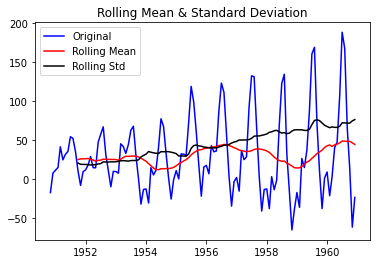

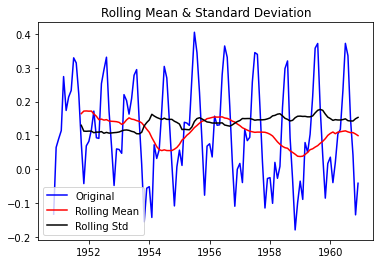

In [10]:
data_dis_apply = (data_sub_mean + data_sub_mean.rolling(window=12).mean().dropna()).dropna()
data_log_dis_apply = (data_log_sub_mean + data_log_sub_mean.rolling(window=12).mean().dropna()).dropna()

test_stationarity_1(data_dis_apply, window_size=12)
test_stationarity_1(data_log_dis_apply, window_size=12)

Viendo los resultados parece que no estamos sumando prácticamente nada. Esto parece que tiene sentido ya que hemos tratado la serie como de media cero.

3. Ahora vemos los resultados a nivel completo, incluyendo el test de Dickey-Fuller.



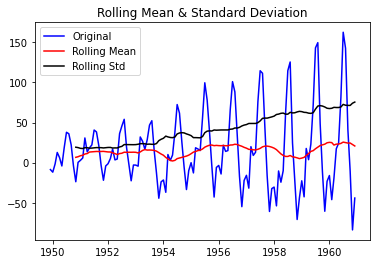

Results of Dickey-Fuller Test:
Test Statistic                  -3.164968
p-value                          0.022104
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


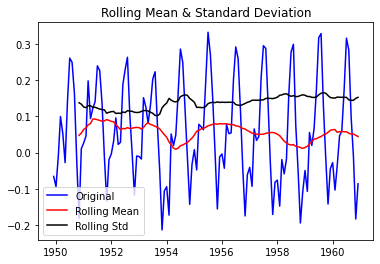

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [13]:
test_stationarity(data_sub_mean, window_size=12)
test_stationarity(data_log_sub_mean, window_size=12)

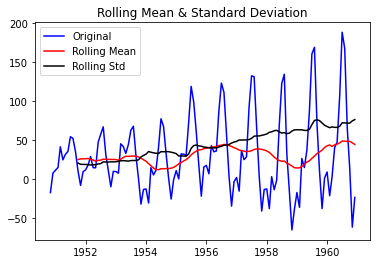

Results of Dickey-Fuller Test:
Test Statistic                  -3.249015
p-value                          0.017317
#Lags Used                      13.000000
Number of Observations Used    108.000000
Critical Value (1%)             -3.492401
Critical Value (5%)             -2.888697
Critical Value (10%)            -2.581255
dtype: float64


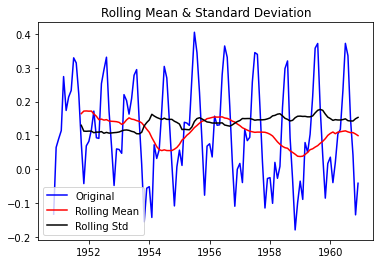

Results of Dickey-Fuller Test:
Test Statistic                  -3.231625
p-value                          0.018226
#Lags Used                      13.000000
Number of Observations Used    108.000000
Critical Value (1%)             -3.492401
Critical Value (5%)             -2.888697
Critical Value (10%)            -2.581255
dtype: float64


In [14]:
test_stationarity(data_dis_apply, window_size=12)
test_stationarity(data_log_dis_apply, window_size=12)

Vemos ahora que el p-valor es menor que $\alpha=0.05$, por lo que podemos rechazar la hipótesis nula y decir que el modelo es estacionario. Podemos comprobar viendo visualmente que la media y la desviación típica son constantes prácticamente, aunque parezca en el primer caso que existe una pequeña tendencia hacia arriba en la desviación típica, apenas es apreciable en escala.

b) *Diferenciar (derivar)*:

Las técnicas anteriores son sencillas y pueden eliminar parte de la influencia de la tendencia de la serie, pero no suelen ser suficientes cuando se tiene por ejemplo estacionalidad. 

Diferenciar (o derivar) es uno de los métodos más comunes para eliminar la influencia de la tendencia y la estacionalidad en la serie original, mejorando las propiedades de estacionariedad de la serie. 

Podemos tomar la derivada de orden uno de la siguiente manera (partimos de la serie en el dominio logarítmico): 

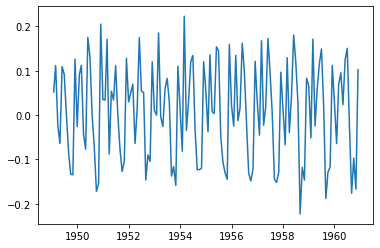

In [34]:
data_log_diff = (data_log - data_log.shift()).dropna()
plt.plot(data_log_diff)

**PREGUNTAS**


1.   ¿Qué observas en la serie resultante?
2.   ¿Es esta serie estacionaria de acuerdo a los criterios anteriores? Incluye los resultados gráficos y del test estadístico e interprétalos.
3. Repite el proceso para una segunda derivada. ¿Qué observas ahora?



**RESPUESTAS**

1. La serie parece, a priori, una serie estacionaria, ya que su media parece muy cercana a cero y apenas se sale excesivamente de $[-2, 2]$.

2. A través del test...

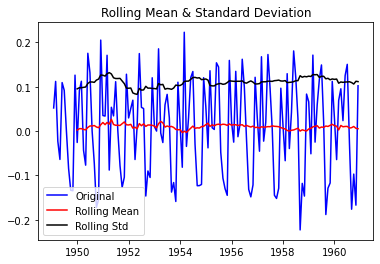

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [35]:
test_stationarity(data_log_diff, window_size=12)

Podemos ver en general que la serie es estacionaria, observando que la media y la desviación típica parecen constantes y que el test de Dickey-Fuller obtiene un p-valor de $0.07$ aproximadamente, lo cual nos lleva a rechazar la hipótesis nula, y decimos que es estacionaria.

3. Ahora realizamos el proceso para la segunda derivada.

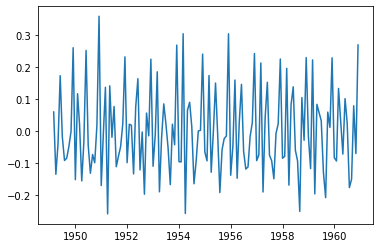

In [36]:
data_log_diff2 = (data_log_diff - data_log_diff.shift()).dropna()
plt.plot(data_log_diff2)

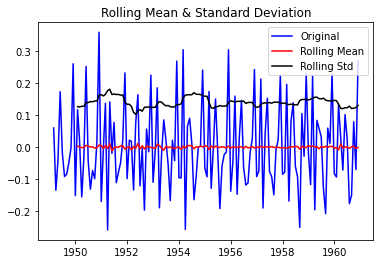

Results of Dickey-Fuller Test:
Test Statistic                -8.196629e+00
p-value                        7.419305e-13
#Lags Used                     1.300000e+01
Number of Observations Used    1.280000e+02
Critical Value (1%)           -3.482501e+00
Critical Value (5%)           -2.884398e+00
Critical Value (10%)          -2.578960e+00
dtype: float64


In [37]:
test_stationarity(data_log_diff2, window_size=12)

De nuevo vemos que la serie es estacionaria, tanto con el test de Dickey-Fuller como analizando de manera visual.

c) *Descomposición de la serie*:

La mayoría de series pueden descomponerse en tendencia, estacionalidad y residuo, como hemos visto en clase. 

Utilizando la función *seasonal_decompose* del módulo de Python *statsmodels* podemos obtener estas tres componentes y por tanto, modelarlas por separado: 

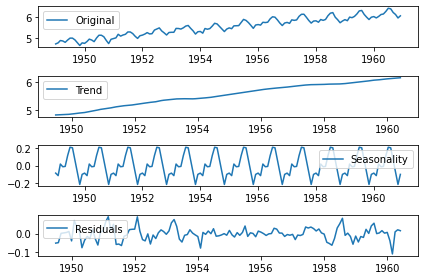

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(data_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

**PREGUNTAS**

1.   ¿Es la señal residual estacionaria? Realiza el test y comenta los resultados.



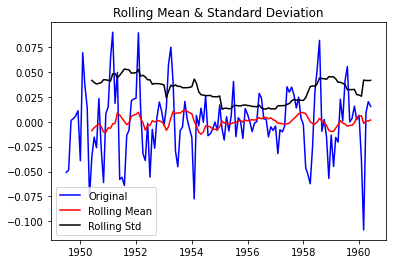

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [19]:
test_stationarity(residual.dropna(), 12)

Sí, es estacionaria. Lo podemos comprobar de la misma manera que llevamos haciendo hasta ahora, observando que la media y la desviación típica son constantes y que el p-valor es muy inferior al nivel de significancia de $0.05$, por tanto rechazamos la hipótesis nula, intuyendo que la serie es estacionaria.

## 1.5. Modelado ARIMA y predicción

Uno de los modelos clásicos para series temporales vistos en clase es el modelo ARIMA, que permite derivar *d* veces, y aplicar *p* coeficientes autorregresivos (AR) y *q* términos de error (shocks, provenientes de la parte MA) en la combinación lineal.  

Para determinar el valor de los parámetros *p* y *q*, podemos hacer uso de las funciones de autocorrelación (ACF) y autocorrelación parcial (PACF). 

Si calculamos dichas funciones para la serie derivada previamente, obtenemos lo siguiente:

In [14]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

In [29]:
#!pip install -U statsmodels

Text(0.5, 1.0, 'Partial Autocorrelation Function')

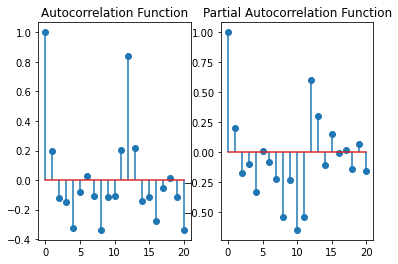

In [27]:
lag_acf = acf(data_log_diff, nlags=20, fft=False)
lag_pacf = pacf(data_log_diff, nlags=20, method='ols') # regression of time series on lags of it and on constant

#Plot ACF: 
plt.subplot(121) 
plt.stem(lag_acf,use_line_collection=True)
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.stem(lag_pacf,use_line_collection=True)
plt.title('Partial Autocorrelation Function')

Podemos añadir además un intervalo de confianza a ambos lados del valor cero, de tal manera que el primer valor de retardo que cruce ese intervalo por arriba en la función de PACF será el valor de *p*, y de ACF, será *q*.

Para los niveles de confianza estándar, el valor del límite del intervalo de confianza al 95% es 1.96. Suponiendo desviación estándar unidad, el límite estaría en (-1.96/sqrt(N), 1.96/sqrt(N)), donde N es el número de puntos. 

Si incluimos estos límites en la figura anterior, podemos obtener una buena aproximación de los valores de *p* y *q* para el modelo ARIMA:

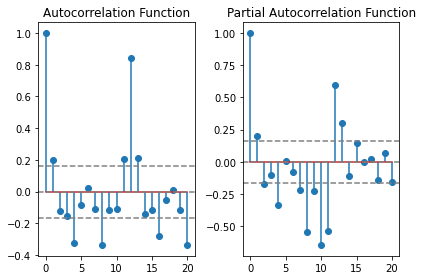

In [28]:
#Plot ACF: 
plt.subplot(121) 
plt.stem(lag_acf,use_line_collection=True)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.stem(lag_pacf,use_line_collection=True)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

**PREGUNTAS**


1.   ¿Qué valores de *p* y *q* utilizarías para un primer modelo ARIMA de acuerdo a las representaciones anteriores?



**RESPUESTAS**

Considerando el modelo ARIMA(p, d, q).

En general, según la teoría:

* $p$, tal que el valor de la PACF es mayor que el valor límite del intervalo establecido para la PACF tiene desplazamiento $p$.
* $q$, tal que el valor de la ACF es mayor que el valor límite del intervalo establecido para la ACF tiene desplazamiento $q$.

Vemos que para $desplazamiento=1$, se supera el umbral por lo que escogemos $p=q=1$.


Una vez elegidos los valores de *p* y *q*, podemos utilizar también la derivación interna de la clase ARIMA (*d*) o aplicarlo sobre la serie previamente derivada con valor de *d=0*. 

A continuación, importamos el modelo ARIMA de la siguiente manera. 

Este modelo tiene como argumentos los datos, y el orden: 

model = ARIMA(datos, order = ($p,d,q$))

In [17]:
#from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA


**PREGUNTAS**


1.   A continuación, completa los valores de p, d y q y utiliza el siguiente código para ajustar un modelo tipo AR. Incluye el resultado en el informe de la práctica así como los valores elegidos. ¿Qué error de ajuste (RSS) se obtiene?

2.    Repite el código con los valores de los parámetros correspondientes para ajustar un modelo MA. Incluye el resultado en el informe de la práctica así como los valores elegidos. ¿Qué error de ajuste (RSS) se obtiene?

3.    Repite nuevamente el código para combinar los modelos anteriores (ARMA). Incluye el resultado en el informe de la práctica así como los valores elegidos. ¿Qué error de ajuste (RSS) se obtiene?

4.   De acuerdo a los valores de RSS, ¿cuál dirías que es el modelo que mejor se ajusta a los datos?

**RESPUESTAS**

1. Ajustamos el modelo AR, que tendrá $p=1$ y $q=0$, porque es de orden $p$.

In [18]:
def plot_ARIMA(data, results, title):
    _ = plt.plot(data,color = "blue", label = "Differenced data")
    _ = plt.plot(results.fittedvalues, color='red',label = "Predictions")
    _ = plt.title(title + ' RSS: %.4f'% sum((results.fittedvalues-data)**2))
    _ = plt.legend()

/root/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/root/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/root/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Text(0.5, 1.0, 'RSS: nan')

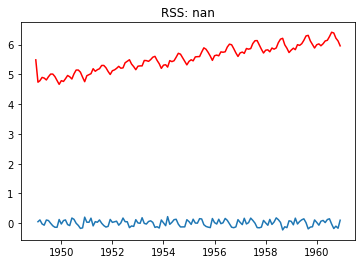

In [19]:
p = 1
d = 0
q = 0

# AR
model = ARIMA(data_log, order=(p, d, q))  
results_AR = model.fit()  
plt.plot(data_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-data_log_diff)**2)) 
# RSS: Residual sum of squares

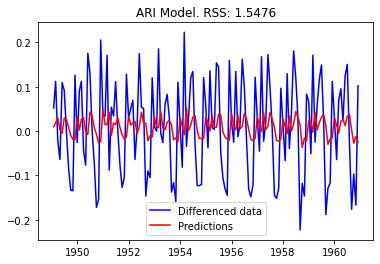

In [20]:
p = 1
d = 0
q = 0

data_log_diff = data_log_diff.resample('MS').last().dropna()


# AR
model = ARIMA(data_log_diff, order=(p, d, q))  
results_AR = model.fit()
plot_ARIMA(data_log_diff, results_AR, title = "ARI Model.")

Parece que no ajusta bien los datos, y tiene un error grande para la poca escala que tenemos en este caso.

2. Ahora ajustamos el modelo MA, por lo que $q=1$ y $p=0$, ya que es de orden $q$.

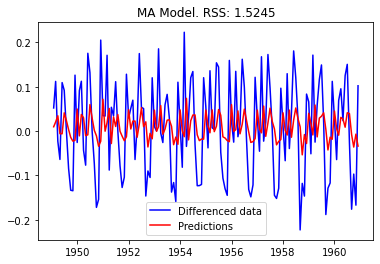

In [21]:
p = 0
d = 0
q = 1

# MA
model = ARIMA(data_log_diff, order=(p, d, q),freq = 'MS', enforce_invertibility=True)  
results_MA = model.fit() 
plot_ARIMA(data_log_diff,results_MA, title = "MA Model.")

Vemos que tenemos un efecto muy similar por lo que vamos a necesitar un modelo más completo.

3. Ahora probamos ARMA, con $p=q=1$, que une ambos modelos anteriores.

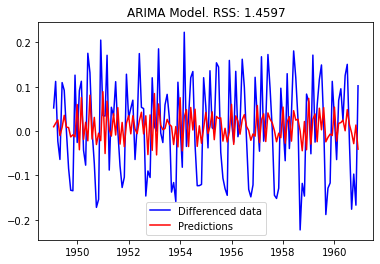

In [22]:
p = 1
d = 0
q = 1

# AR
model = ARIMA(data_log_diff, order=(p, d, q),freq = 'MS', enforce_invertibility=True)  
results_ARIMA = model.fit() 
plot_ARIMA(data_log_diff,results_ARIMA, title = "ARIMA Model.")

Las predicciones parecen algo mejores, pero tampoco mejoran en exceso con los resultados anteriores.

Por último, para predecir valores en el espacio original, tenemos que deshacer las transformaciones realizadas hasta el momento. 

Primero, tomamos los valores ajustados por el modelo (predicciones) y los guardamos como serie temporal. 

Estos valores empiezan en el segundo mes, puesto que hemos tomado diferencias (derivada) de orden 1.

In [23]:
# Predicciones en el espacio original
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())


Month
1949-02-01    0.009797
1949-03-01    0.017616
1949-04-01    0.025227
1949-05-01   -0.010229
1949-06-01    0.008525
Freq: MS, dtype: float64


Segundo, deshacemos la operación de diferencias (en escala logarítmica), con una suma acumulativa y añadiéndoles el valor "base" (primer elemento de la serie). 

In [24]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Month
1949-02-01    0.009797
1949-03-01    0.027412
1949-04-01    0.052639
1949-05-01    0.042410
1949-06-01    0.050935
Freq: MS, dtype: float64


In [25]:
predictions_ARIMA_log = pd.Series(data_log[0], index=data_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
print(predictions_ARIMA_log.head())

Month
1949-01-01    4.718499
1949-02-01    4.728295
1949-03-01    4.745911
1949-04-01    4.771138
1949-05-01    4.760909
dtype: float64


Finalmente, aplicamos la función exponencial (inversa del logaritmo).

Podemos calcular el error cuadrático medio en el espacio original. 

Text(0.5, 1.0, 'RMSE: 52.5406')

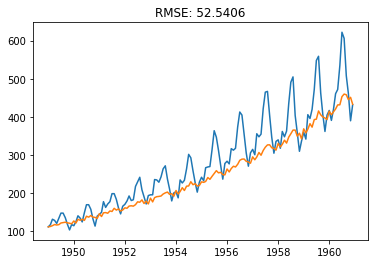

In [26]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(data)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-data)**2)/len(data)))

Finalmente vemos que se mantiene la tendencia de la serie y que obtenemos un error que parece, a priori, bastante alto.

# 2. Aplicación a otros datos: Vacunación COVID República Checa


Vamos a cargar ahora los datos sobre la vacunación COVID de República Checa (*COVIDVaccinationCZ.csv*):

In [ ]:
from google.colab import files
uploaded = files.upload()

Esta base de datos, contiene los datos de vacunación de República Checa desde el 27 de diciembre de 2020 hasta el 7 de febrero de 2022. 

In [38]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
 
def parser(x):
	return datetime.strptime(x, '%Y-%m-%d')
 
data = read_csv('COVIDVaccinationCZ.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(data.head())

Fecha
2020-12-27    1283
2020-12-28    2305
2020-12-29    3464
2020-12-30    3521
2020-12-31    1307
Name: NumVacunas, dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


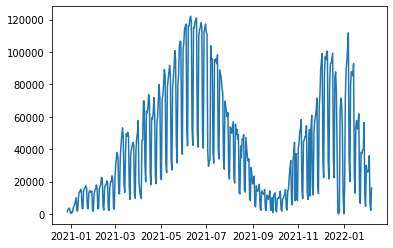

In [39]:
from matplotlib import pyplot as plt
plt.plot(data)

**PREGUNTAS**

Utilizando las herramientas del apartado 1, realiza el análisis de esta serie (puedes utilizar un intervalo de ella o la serie completa). 

En concreto:
1.   Analiza la estacionariedad de esta serie. 
2.   ¿Qué transformaciones puedes realizar para hacerla más estacionaria? Prueba algunas y justifica si consigues una serie más estacionaria. 
3.   Ajusta un modelo ARIMA, y calcula el error de predicción. 



**RESPUESTAS**

1. Comenzamos realizando el análisis de estacionareidad, tal y como llevamos realizando hasta ahora.

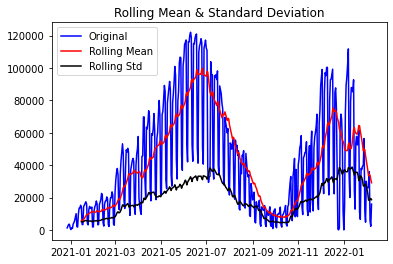

Results of Dickey-Fuller Test:
Test Statistic                  -2.052545
p-value                          0.264019
#Lags Used                      14.000000
Number of Observations Used    393.000000
Critical Value (1%)             -3.447099
Critical Value (5%)             -2.868923
Critical Value (10%)            -2.570703
dtype: float64


In [40]:
#### CÓDIGO AQUÍ ####

test_stationarity_1(data, 20)
test_stationarity_2(data)

Observando los resultados, vemos que la serie parece no estacionaria, ya que ni la media ni la desviación típica parecen constantes. Observando el p-valor, vemos que es superior al nivel de significancia $\alpha=0.05$, por tanto no tenemos evidencias para rechazar la hipótesis nula y concluimos con que la serie no es estacionaria.

2. Ahora aplicamos transformaciones.

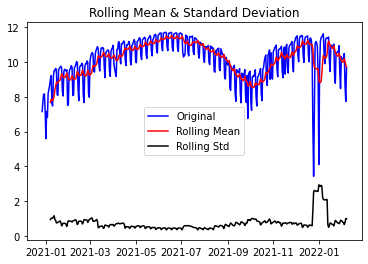

In [41]:
data_log = data.apply(np.log)
test_stationarity_1(data_log, window_size=12)

Tras aplicar el logaritmo, vemos que la serie sigue sin ser estacionaria, por lo que aplicamos un suavizado por moving average igual que para el otro dataset.

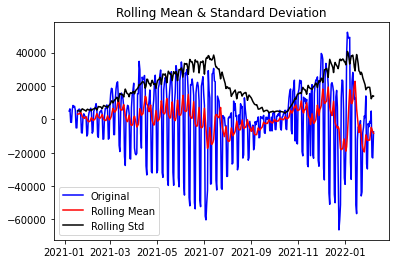

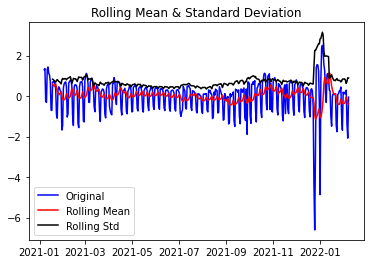

In [42]:
data_sub_mean = (data-data.rolling(window = 12).mean().dropna()).dropna()
data_log_sub_mean = (data_log-data_log.rolling(window = 12).mean().dropna()).dropna()
test_stationarity_1(data_sub_mean, window_size=12)
test_stationarity_1(data_log_sub_mean, window_size=12)

No parece que en el caso de los datos sin aplicar el logaritmo mejore, si bien realizándolo con el logaritmo se consigue una evidente mejora y se "estacionariza" la serie. Si bien, parece que en el mes de diciembre de 2021 existe un pico en los datos. En general viendo la escala se considera que no es muy relevante ya que el error es poco apreciable.

Vamos a ver qué pasa ahora diferenciando los datos.

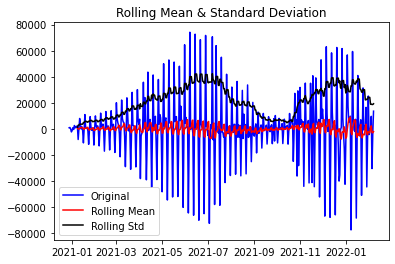

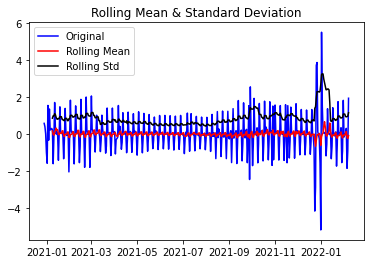

In [43]:
data_diff = (data - data.shift()).dropna()
data_log_diff = (data_log - data_log.shift()).dropna()

test_stationarity_1(data_diff, window_size=12)
test_stationarity_1(data_log_diff, window_size=12)

Vemos que ocurre un caso muy similar al anterior: en los datos originales no tenemos estacionareidad, si bien en los datos aplicados con el logaritmo sí, salvo por ese pico en el mismo mes.

Ahora vemos lo que ocurre aplicando la segunda derivada.

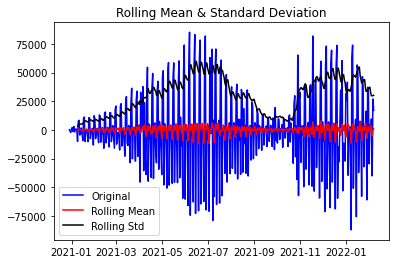

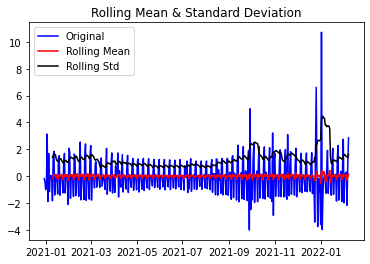

In [44]:
data_second_diff = (data_diff - data_diff.shift()).dropna()
data_log_second_diff = (data_log_diff - data_log_diff.shift()).dropna()


test_stationarity_1(data_second_diff, window_size = 12)
test_stationarity_1(data_log_second_diff, window_size = 12)

Finalmente vemos que las transformaciones realizadas no hacen que la serie sea lo más estacionaria posible y que la segunda derivada apenas realiza un cambio respecto de las transformaciones previas.

3. Ajustamos el modelo ARIMA, con los datos del logaritmo diferenciados.

Text(0.5, 1.0, 'Partial Autocorrelation Function')

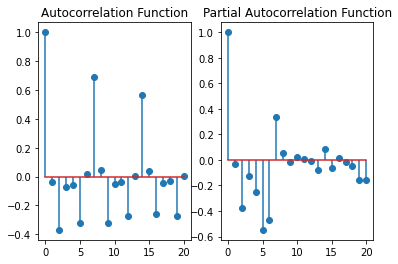

In [45]:
lag_acf = acf(data_log_diff, nlags=20, fft=False)
lag_pacf = pacf(data_log_diff, nlags=20, method='ols') # regression of time series on lags of it and on constant

#Plot ACF: 
plt.subplot(121) 
plt.stem(lag_acf,use_line_collection=True)
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.stem(lag_pacf,use_line_collection=True)
plt.title('Partial Autocorrelation Function')

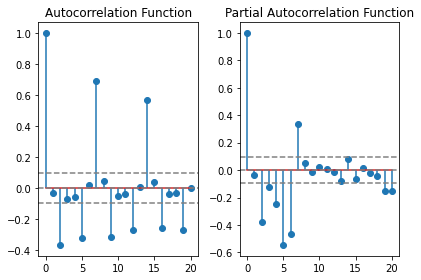

In [46]:
#Plot ACF: 
plt.subplot(121) 
plt.stem(lag_acf,use_line_collection=True)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.stem(lag_pacf,use_line_collection=True)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

/root/.local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/root/.local/lib/python3.7/site-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


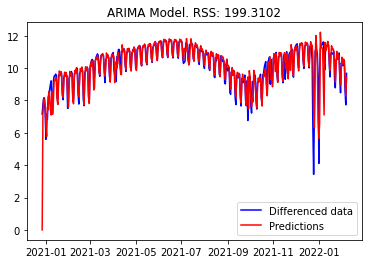

In [51]:
p = 6
d = 1 # debido a la diferenciación que hemos realizado
q = 2


model = ARIMA(data_log, order=(p, d, q),freq = 'D', enforce_invertibility=True)  
results_covid = model.fit() 
plot_ARIMA(data_log,results_covid, title = "ARIMA Model.")

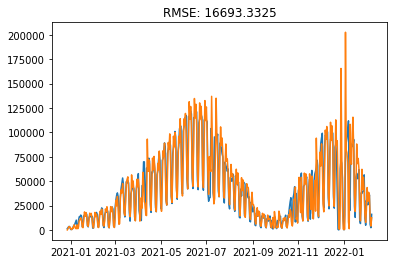

In [52]:
predictions_covid = pd.Series(results_covid.fittedvalues, copy=True)
predictions_covid_cumsum = predictions_covid.cumsum()

predictions_ARIMA = np.exp(predictions_covid)
_ = plt.plot(data)
_ = plt.plot(predictions_ARIMA)
_ = plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-data)**2)/len(data)))

Vemos que obtenemos un error bastante alto, si bien es lo menor que hemos obtenido tras realizar diversas pruebas con $p$ y $q$.